In [1]:
from SafeTransformer import SafeTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from copy import deepcopy

In [2]:
titanic = pd.read_csv("titanic_train.csv")
y = titanic["Survived"]
X = titanic.drop(["PassengerId", "Survived", "Name", "Ticket"], axis=1)

X["Embarked"] = X["Embarked"].astype('category')
X["Cabin"] = X["Cabin"].fillna("unknown")
X["Cabin"] = X["Cabin"].astype('category')
X["Sex"] = X["Sex"].astype('category')

# Filling NaNs

In [3]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [4]:
fill_NaN_pipeline = make_pipeline(
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            SimpleImputer(strategy="median"),
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            SimpleImputer(strategy="most_frequent"),
        ))
    ])
)

In [5]:
X_filled = fill_NaN_pipeline.fit_transform(X)
ts_category = TypeSelector("category")
colnames_category = ts_category.fit_transform(X).columns
ts_numeric = TypeSelector(np.number)
colnames_numeric = ts_numeric.fit_transform(X).columns
colnames = colnames_numeric.append(colnames_category)
X_filled = pd.DataFrame(X_filled, columns=colnames)
X_filled.head()

,Pclass,Age,SibSp,Parch,Fare,Sex,Cabin,Embarked
0,3,22,1,0,7.25,male,unknown,S
1,1,38,1,0,71.2833,female,C85,C
2,3,26,0,0,7.925,female,unknown,S
3,1,35,1,0,53.1,female,C123,S
4,3,35,0,0,8.05,male,unknown,S


In [6]:
for col in X.columns:
    X_filled[col] = X_filled[col].astype(X[col].dtype)
X_filled.dtypes

Pclass         int64
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Sex         category
Cabin       category
Embarked    category
dtype: object

# Data set with dummy variables and splits

In [7]:
X_dummy = X_filled.copy()
colnames = list(X_dummy)
for idx, name in enumerate(colnames):
    if str(X_dummy.loc[:, name].dtype) in ['category', 'object']:
        dummies = pd.get_dummies(X_dummy.loc[:, name], prefix=name, drop_first=True)
        dummy_index  = X_dummy.columns.get_loc(name)
        X_dummy = pd.concat([X_dummy.iloc[:,range(dummy_index)], dummies, X_dummy.iloc[:, range(dummy_index+1, len(X_dummy.columns))]], axis=1)

In [8]:
X_train, X_test, X_lin_train, X_lin_test, y_train, y_test = train_test_split(X_filled, X_dummy, y, random_state = 123)

# SAFE

logistic regression

In [9]:
logistic_model = LogisticRegression(solver='liblinear')
logistic_model = logistic_model.fit(X_lin_train, y_train)
standard_predictions = logistic_model.predict(X_lin_test)
print(accuracy_score(y_test, standard_predictions))

0.7982062780269058


surrogate model

In [10]:
surrogate_model = XGBClassifier(eval_metric = 'auc', random_state = 123,
                               subsample = 0.8, n_estimators = 200, min_child_weight = 3, 
                                max_depth = 6, learning_rate = 0.4, reg_lambda = 0.8, 
                                gamma = 1.5, colsample_bytree = 0.8)
surrogate_model = surrogate_model.fit(X_lin_train, y_train)
surrogate_model_predictions = surrogate_model.predict(X_lin_test)
print(accuracy_score(y_test, surrogate_model_predictions))

0.8475336322869955


white-box model (logistic regression)

In [11]:
pens = range(1, 10)
best_score = float('-Inf')
best_pen = 0
aucs = []

for pen in pens:
    surrogate_model = XGBClassifier(eval_metric = 'auc', random_state = 123,
                               subsample = 0.8, n_estimators = 200, min_child_weight = 3, 
                                max_depth = 6, learning_rate = 0.4, reg_lambda = 0.8, 
                                gamma = 1.5, colsample_bytree = 0.8)
    logistic_model_simple = LogisticRegression(solver='liblinear')
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)
    pipe = Pipeline(steps=[('safe', safe_transformer), ('linear', logistic_model_simple)])
    pipe = pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    auc = accuracy_score(y_test, predictions)
    aucs.append(auc)
    print([pen,auc])
    if auc > best_score:
        best_transformer = deepcopy(safe_transformer)
        best_model = deepcopy(logistic_model_simple)
        best_score = auc
        best_pen = pen

[1, 0.8251121076233184]
[2, 0.820627802690583]
[3, 0.820627802690583]
[4, 0.8071748878923767]
[5, 0.8026905829596412]
[6, 0.8026905829596412]
[7, 0.8026905829596412]
[8, 0.8026905829596412]
[9, 0.8026905829596412]


In [12]:
best_score

0.8251121076233184

## Plot

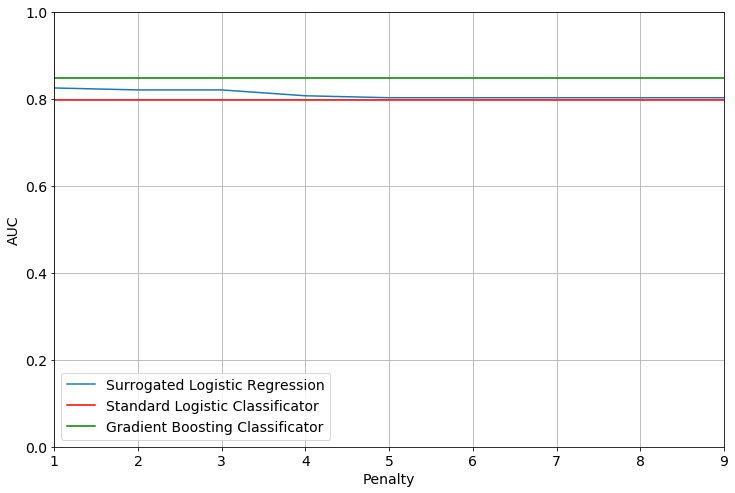

In [13]:
standard_auc = accuracy_score(y_test, standard_predictions)
xgb_auc = accuracy_score(y_test, surrogate_model_predictions)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 14})
plt.plot(pens[0:], aucs[0:], label='Surrogated Logistic Regression')
plt.xlabel('Penalty')
plt.ylabel('AUC')
plt.grid(True)
plt.axhline(standard_auc, color='r', label='Standard Logistic Classificator')
plt.axhline(xgb_auc, color='g', label='Gradient Boosting Classificator')
plt.ylim((0, 1))
plt.xlim((1,max(pens)))
plt.legend()
plt.show()

# Summaries

In [14]:
safe_transformer.summary()

Numerical Variable Pclass
Selected intervals:
	[-Inf, Inf)
Numerical Variable Age
Selected intervals:
	[-Inf, 9.58)
	[9.58, 36.27)
	[36.27, Inf)
Numerical Variable SibSp
Selected intervals:
	[-Inf, Inf)
Numerical Variable Parch
Selected intervals:
	[-Inf, Inf)
Numerical Variable Fare
Selected intervals:
	[-Inf, Inf)
Categorical Variable Sex
Created variable levels:
	 -> 

Categorical Variable Cabin
Created variable levels:
	A10, A14, A16, A19, A20, A23, A24, A26, A31, A32, A34, A36, A5, A6, A7, B101, B102, B18, B19, B20, B22, B28, B3, B30, B35, B37, B38, B39, B4, B41, B42, B49, B5, B50, B51 B53 B55, B57 B59 B63 B66, B58 B60, B69, B71, B73, B77, B78, B79, B80, B82 B84, B86, B94, B96 B98, C101, C103, C104, C106, C110, C111, C118, C123, C124, C125, C126, C128, C148, C2, C22 C26, C23 C25 C27, C30, C32, C45, C46, C47, C49, C50, C52, C54, C62 C64, C65, C68, C7, C70, C78, C82, C83, C85, C86, C87, C90, C91, C92, C93, C95, C99, D, D10 D12, D11, D15, D17, D19, D20, D21, D26, D28, D30, D33, D35, 

In [15]:
safe_transformer.summary(variable_name = "Sex")

Categorical Variable Sex
Created variable levels:
	 -> 

